In [2]:

import matplotlib.pyplot as plt
import numpy as np
import xlrd
from arch.bootstrap import SPA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model


In [3]:
# read the data from the csv file /home/vishi/bolinger/22-05cumul_ohlc_diff_percent.csv

df = pd.read_csv('/home/vishi/bolinger/22-05cumul_ohlc_diff_percent.csv', index_col=0, parse_dates=True)
df.head()

,open,high,low,close,close_diff_percent,close_moving_avg,std,upper_bb,lower_bb,close_diff,close_scaled_down
DateTime,,,,,,,,,,,
2024-12-31 09:16:00,2355950,2356430,2354005,2355135,NaN,NaN,NaN,NaN,NaN,NaN,2355.135
2024-12-31 09:17:00,2355070,2356150,2354500,2355915,3.311912,NaN,NaN,NaN,NaN,780.0,2355.915
2024-12-31 09:18:00,2355980,2356025,2355100,2355405,-2.164764,NaN,NaN,NaN,NaN,-510.0,2355.405
2024-12-31 09:19:00,2355400,2357195,2355215,2356905,6.368332,NaN,NaN,NaN,NaN,1500.0,2356.905
2024-12-31 09:20:00,2356960,2357015,2355475,2355475,-6.067279,NaN,NaN,NaN,NaN,-1430.0,2355.475


In [4]:
def forcast_next_minute(_20_minute_data, order_arima=(1, 1, 1), order_arch=(1, 1)):
    """
    Forecast the next minute using ARIMA and ARCH models.
    :param _20_minute_data: DataFrame with 20 minutes of data
    :param order_arima: Order of the ARIMA model
    :param order_arch: Order of the ARCH model
    :return: Forecasted value for the next minute
    """
    # Fit ARIMA model
    arima_model = ARIMA(_20_minute_data, order=order_arima)
    arima_result = arima_model.fit()
    # forecast the next minute using ARIMA model
    arima_forecast = arima_result.forecast(steps=1)

    # Fit ARCH model
    arch_model_fit = arch_model(arima_result.resid, vol='GARCH', p=order_arch[0], q=order_arch[1]).fit(disp="off")

    # Forecast next minute
    forecast = arch_model_fit.forecast(horizon=1)
    
    return arima_forecast, forecast

In [5]:
def rolling_forecast(df, window_size=20, order_arima=(1, 1, 1), order_arch=(1, 1)):
    """
    Perform rolling forecast on the DataFrame.
    :param df: DataFrame with the data
    :param window_size: Size of the rolling window
    :param order_arima: Order of the ARIMA model
    :param order_arch: Order of the ARCH model
    :return: List of forecasted values
    """
    forecasts_mid = []
    forecast_vol = []

    
    for i in range(window_size, len(df)):
        _20_minute_data = df.iloc[i-window_size:i]
        arima_forecast, garch_forecast = forcast_next_minute(_20_minute_data, order_arima, order_arch)
        forecasts_mid.append(arima_forecast)
        forecast_vol.append(garch_forecast.variance.values[0][0])  # Get the last forecasted varianc
    
    return forecasts_mid, forecast_vol

In [22]:
data = df["close_scaled_down"].loc["2025-02-01":"2025-02-05"]/10
forecasts_mid, forecast_vol = rolling_forecast(data, window_size=20, order_arima=(1, 1, 1), order_arch=(1, 1))


/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/stat

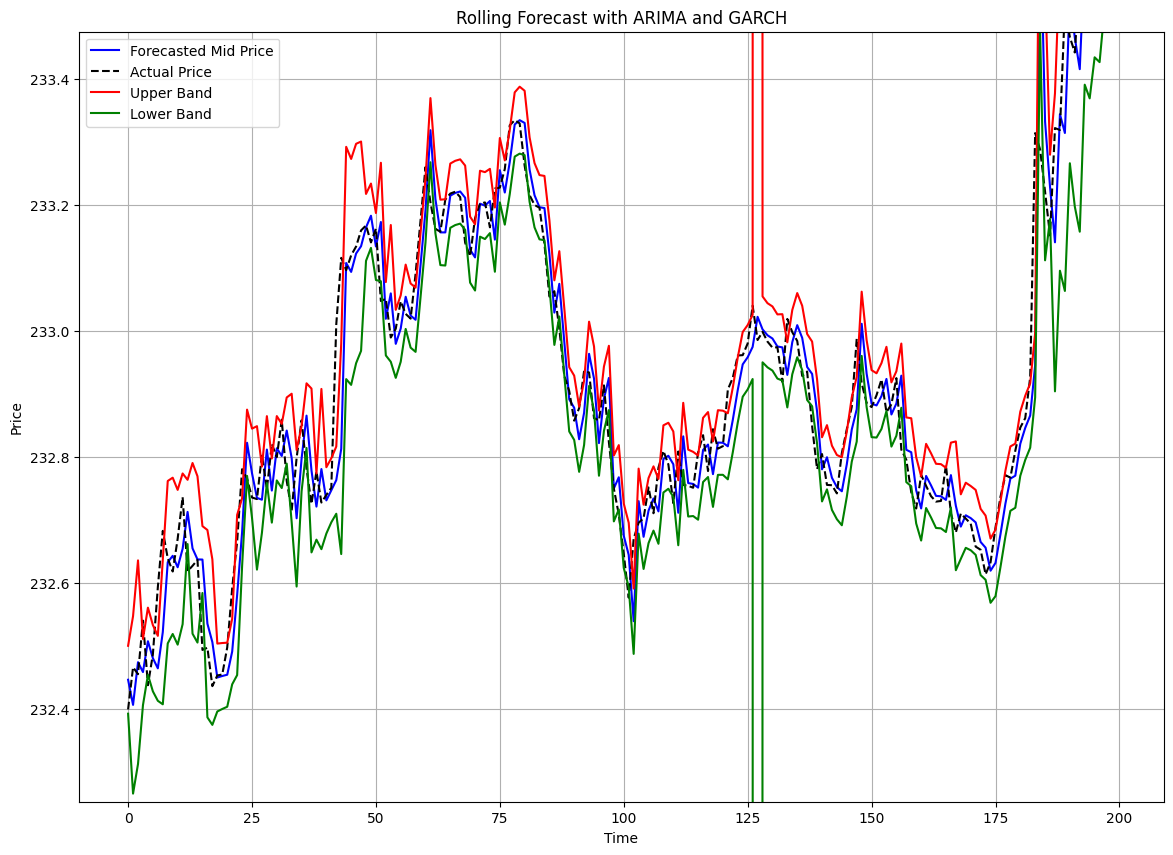

In [28]:
forecasts_mid_np =  np.array(forecasts_mid).flatten()
forecast_vol_np = np.array(forecast_vol).flatten()
upper_band_np = forecasts_mid_np + 2 * np.sqrt(forecast_vol_np)
lower_band_np = forecasts_mid_np - 2 * np.sqrt(forecast_vol_np)


plt.figure(figsize=(14, 10))
plt.plot(forecasts_mid_np[400:600], label='Forecasted Mid Price', color='blue')
plt.plot( data.values[420:620], label='Actual Price', color='black', linestyle='--')    
plt.plot(upper_band_np[400:600], label='Upper Band', color='red')
plt.plot(lower_band_np[400:600], label='Lower Band', color='green')


plt.ylabel('Price')
# zoom yaxis to the range of the data
plt.ylim(data.min() , data.max() -4.5)
# )+ 0.1)
plt.xlabel('Time')
plt.title('Rolling Forecast with ARIMA and GARCH')
plt.legend()
plt.grid()
plt.show()